In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
# Function for Confusion Matrix plot
def plot_cf_matrix(confusion_matrix):
  '''
  Takes as input a binary confusion matrix and plots heatmap using seaborn with annotated labels.
  Also computes accuracy, precision, recall and F1-score to include in the plot.
  '''
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sns.set(rc = {'figure.figsize':(10,5)})
  sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
  accuracy  = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
  precision = confusion_matrix[1,1] / sum(confusion_matrix[:,1])
  recall = confusion_matrix[1,1] / sum(confusion_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  plt.title('Confusion Matrix')
  return

In [ ]:
basic_train = pd.read_csv('/content/data-capture-zoom.csv')
basic_train.head()

,No.,Time,Source,Destination,Protocol,Length,Packet Time Interval,Info,Person
0,1,0.000000,206.247.87.104,192.168.1.52,UDP,1245,0.000000,8801 > 49688 Len=1203,1
1,2,0.000000,206.247.87.104,192.168.1.52,UDP,1245,0.000000,8801 > 49688 Len=1203,1
2,3,0.000000,206.247.87.104,192.168.1.52,UDP,1078,0.000000,8801 > 49688 Len=1036,1
3,4,0.010101,206.247.87.104,192.168.1.52,UDP,1078,0.010101,8801 > 49688 Len=1036,1
4,5,0.010101,206.247.87.104,192.168.1.52,UDP,1078,0.000000,8801 > 49688 Len=1036,1


In [ ]:
# Data cleanup
basic_train.drop(basic_train[(basic_train['Protocol'] == "DNS") | (basic_train['Protocol'] == "SSDP")].index, inplace = True)
basic_train.shape

(168060, 9)

In [ ]:
# Feature engineering
time_window = 0.5
df = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False).agg(avg_packet_arrival_time=('Packet Time Interval', 'mean'), avg_packet_length=('Length', 'mean'))
df['packet_rate'] = (df['avg_packet_length']*8) / df['avg_packet_arrival_time']
df['total_packets'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False)['No.'].count()
df['outbound_packets'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False)['Source'].apply(lambda x: (x=='192.168.1.52').sum())
df['inbound_packets'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False)['Destination'].apply(lambda x: (x=='192.168.1.52').sum())
df['std_packet_arrival_time'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False)['Packet Time Interval'].std()
df['std_packet_length'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False)['Length'].std()
df['std_total_packets'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False)['No.'].std()
df['person'] = basic_train.groupby(pd.cut(basic_train["Time"], np.arange(0, 720, time_window)), sort=False).agg({'Person':'first'})
df

,avg_packet_arrival_time,avg_packet_length,packet_rate,total_packets,outbound_packets,inbound_packets,std_packet_arrival_time,std_packet_length,std_total_packets,person
Time,,,,,,,,,,
"(0.0, 0.5]",0.002319,1128.350711,3.891978e+06,211,48,163,0.004328,218.927103,61.813132,1
"(0.5, 1.0]",0.002307,1160.874419,4.025840e+06,215,56,159,0.004221,150.010399,62.209324,1
"(1.0, 1.5]",0.002112,1102.799107,4.176925e+06,224,59,165,0.004048,255.557791,66.682809,1
"(1.5, 2.0]",0.002288,1139.627907,3.984235e+06,215,51,164,0.004328,162.419559,62.712069,1
"(2.0, 2.5]",0.002302,1162.355140,4.040323e+06,214,54,160,0.004354,153.280727,62.398259,1
...,...,...,...,...,...,...,...,...,...,...
"(717.0, 717.5]",0.004377,1143.533333,2.090241e+06,105,41,64,0.010016,316.524214,30.961047,0
"(717.5, 718.0]",0.003467,1204.686131,2.779772e+06,137,57,80,0.006847,233.403613,40.672497,0
"(718.0, 718.5]",0.004206,1199.033613,2.280647e+06,119,52,67,0.010280,180.255136,34.496377,0


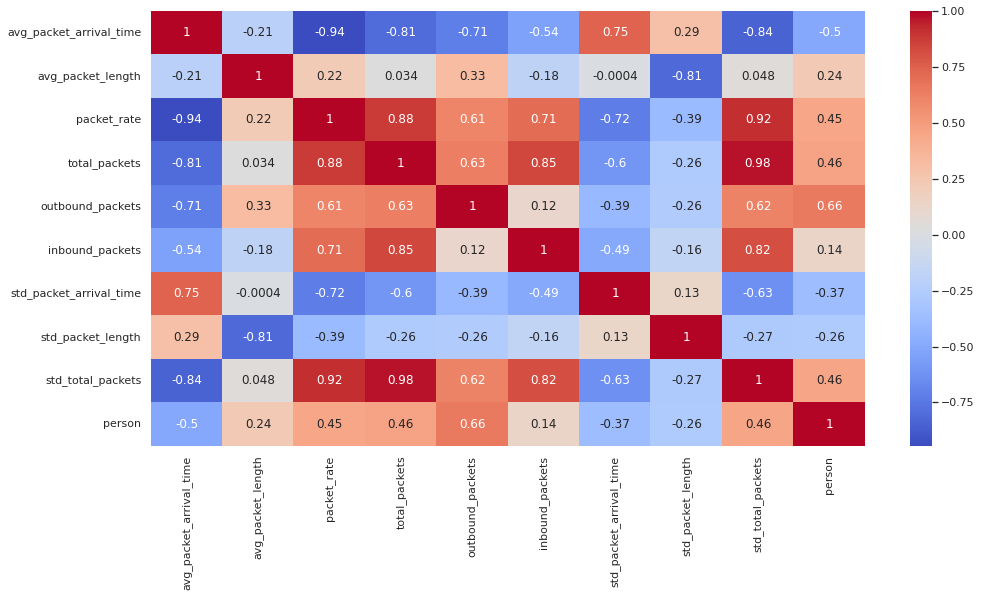

In [ ]:
# Feature correlation heatmap
df.corr()
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [ ]:
# Split Data to Training and Test Set
X = df.drop(['person'], axis=1)
y = df.loc[:, 'person'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

print('Train Data:', X_train.shape)
print('Train Target:', y_train.shape)
print('Test Data:', X_test.shape)
print('Test Target:', y_test.shape)

Train Data: (1007, 9)
Train Target: (1007,)
Test Data: (432, 9)
Test Target: (432,)


In [ ]:
# Train Logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Make prediction
lr_y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


In [ ]:
# Check for overfitting - Accuracy on training set
logreg.score(X_train, y_train)

0.7199602780536246

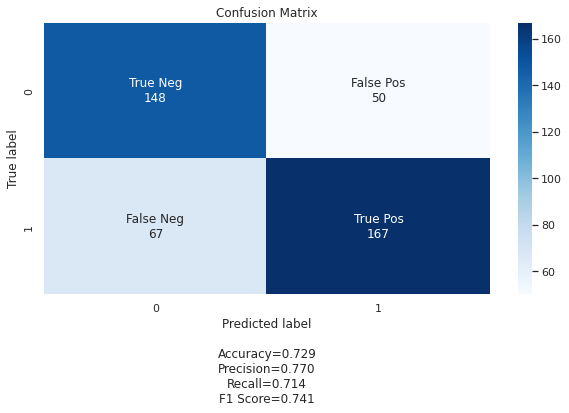

In [ ]:
# Generate and plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, lr_y_pred)
plot_cf_matrix(confusion_matrix)

In [ ]:
# Generate classfication report
print(metrics.classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       198
           1       0.77      0.71      0.74       234

    accuracy                           0.73       432
   macro avg       0.73      0.73      0.73       432
weighted avg       0.73      0.73      0.73       432



In [ ]:
# Train Random Forest classifier
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Make prediction
rfc_y_pred = rfc.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.83


In [ ]:
# Check for overfitting - Accuracy on training set
rfc.score(X_train, y_train)

1.0

In [ ]:
# Hyperparameter Tuning
# For better generalization and to prevent overfitting
# Random search
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
max_features = ['auto', 'sqrt']
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
min_samples_split = [1.0, 2, 5, 10, 15, 20, 30]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1.0, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [ ]:
# Check for output of parameter values from random search
rf_random.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 307}

In [ ]:
# Random Forest model accuracy with parameters obtained using random search
print (rf_random.score(X_train, y_train))
print(rf_random.score(X_test, y_test))

0.8401191658391262
0.8379629629629629


In [19]:
# Grid search
param_grid = {
    'n_estimators': np.linspace(2100, 2300, 5, dtype = int),
    'max_depth': [4, 5, 6],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [3, 4, 5]
}
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = 8, verbose = 2)
grid_rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=8,
             param_grid={'max_depth': [4, 5, 6], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': array([2100, 2150, 2200, 2250, 2300])},
             verbose=2)

In [20]:
# Check for output of parameter values from grid search
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 2200}

In [26]:
# Random Forest model accuracy with parameters obtained using grid search
print (grid_rf_search.score(X_train, y_train))
print(grid_rf_search.score(X_test, y_test))

0.8411122144985105
0.8356481481481481


In [24]:
# Re-train model using grid search parameters
rfc=RandomForestClassifier(max_depth=5,min_samples_leaf=3,min_samples_split=5,n_estimators=2200)
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)

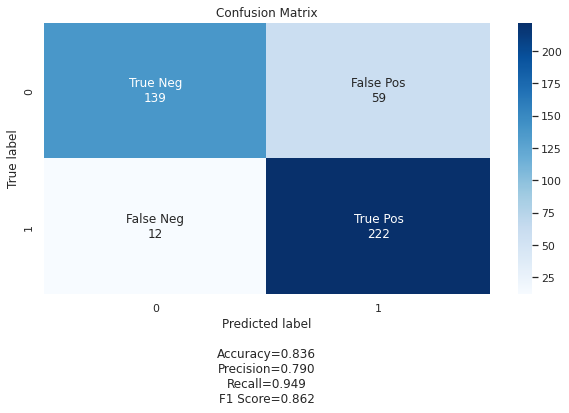

In [25]:
# Generate and plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, rfc_y_pred)
plot_cf_matrix(confusion_matrix)

In [27]:
# Generate classfication report
print(metrics.classification_report(y_test, rfc_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80       198
           1       0.79      0.95      0.86       234

    accuracy                           0.84       432
   macro avg       0.86      0.83      0.83       432
weighted avg       0.85      0.84      0.83       432



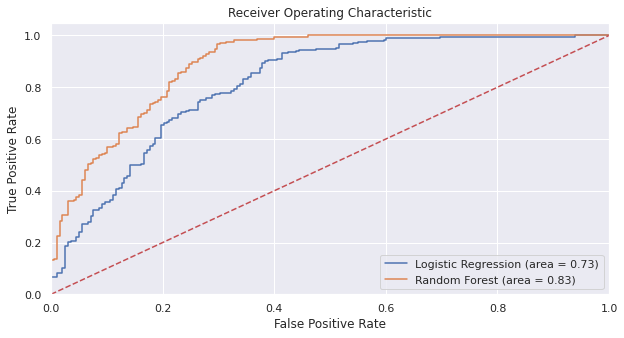

In [28]:
# Plot ROC Curve
logit_roc_auc = metrics.roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
rfc_roc_auc = metrics.roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
# Feature Importance for Random Forest
list(zip(X_train, rfc.feature_importances_))

[('avg_packet_arrival_time', 0.06183990648007945),
 ('avg_packet_length', 0.021954193870609363),
 ('packet_rate', 0.07570788804431579),
 ('total_packets', 0.16170385603403245),
 ('outbound_packets', 0.4042201172521915),
 ('inbound_packets', 0.06035492256271872),
 ('std_packet_arrival_time', 0.046070179681497715),
 ('std_packet_length', 0.028905620582746296),
 ('std_total_packets', 0.13924331549180874)]

In [30]:
# Export ground truth and predictions as csv
y_test.to_csv('ground_truth.csv',index=False)
lr_prediction = pd.DataFrame(lr_y_pred, columns=['lr_y_pred']).to_csv('lr_pred.csv',index=False)
rfc_prediction = pd.DataFrame(rfc_y_pred, columns=['rfc_y_pred']).to_csv('rfc_pred.csv',index=False)